In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [12]:
!pip install mss
!pip install tf_slim
!pip install tensorflow-gpu==1.15.0

     |████████████████████████████████| 358kB 4.9MB/s 
     |████████████████████████████████| 411.5MB 37kB/s 
     |████████████████████████████████| 51kB 3.5MB/s 
     |████████████████████████████████| 3.8MB 33.0MB/s 
     |████████████████████████████████| 512kB 32.4MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=94be16bb6d2cf61186f9638a651a31fc423506f8d84b0a23af4a96011e1b5829
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.4.1 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement tensorboard~=2.4, but you'll have tensorboard 1.15.0 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement tensorflow-estimator<2.5.0,>=2.4.0, but you'll have tensorflow-estimator 1.15.1 which is incompatible.
ERROR: tensorflow-probability 0.12.1 has requirement gast>=0.3.2, but you'll have ga

In [14]:
!dir

build		      faster_rcnn_inception_v2_coco_2018_01_28	tensorflow
CSGO_images	      generate_tfrecord.bat			train.bat
CSGO_inference_graph  generate_tfrecord.py			train.ipynb
CSGO_training	      object_detection.egg-info			train.py
CSGO_training_dir     part_6					xml_to_csv.bat
dist		      predict.ipynb				xml_to_csv.py


In [5]:
%cd /content/gdrive/MyDrive/tresh0.7/coco_v3/

/content/gdrive/MyDrive/tresh0.7/coco_v3


In [13]:
!python part_6/export_inference_graph.py --input_type image_tensor --pipeline_config_path CSGO_images/pipeline.config --trained_checkpoint_prefix CSGO_images/model.ckpt-1328 --output_directory CSGO_inference_graph

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



W0203 06:01:17.547104 140715323824000 module_wrapper.py:139] From part_6/export_inference_graph.py:128: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.

Instructions for updating:
Please use `layer.__call__` method instead.
W0203 06:01:17.868254 140715323824000 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tf_slim/layers/layers.py:2802: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.
INFO:tensorflow:Scale of 0 disables regularizer.
I0203 06:01:

In [25]:
!python part_6/table_object_detection.py




2021-02-03 06:18:55.530560: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-02-03 06:18:55.541647: E tensorflow/stream_executor/cuda/cuda_driver.cc:318] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-02-03 06:18:55.541703: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (c931078b8a2d): /proc/driver/nvidia/version does not exist
2021-02-03 06:18:55.542163: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2021-02-03 06:18:55.547492: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2299995000 Hz
2021-02-03 06:18:55.547735: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x228b100 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-02-03 06:

In [32]:
# # Imports
import time
import cv2
from google.colab.patches import cv2_imshow
import mss
import numpy as np
import os
import sys
#os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import tensorflow as tf
from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO

In [33]:
title = "FPS benchmark"
# set start time to current time
start_time = time.time()
# displays the frame rate every 2 second
display_time = 2
# Set primarry FPS to 0
fps = 0
# Load mss library as sct
#sct = mss.mss()
# Set monitor size to capture to MSS

#monitor = {"top": 80, "left": 0, "width": 800, "height": 640}

import sys
sys.path.append("/content/gdrive/MyDrive/tresh0.7/coco_v3/tensorflow/research/")
sys.path.append("/content/gdrive/MyDrive/tresh0.7/coco_v3/tensorflow/")
sys.path.append("/content/gdrive/MyDrive/tresh0.7/coco_v3/tensorflow/research/slim")

In [34]:
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

In [35]:
# # Model preparation 
PATH_TO_FROZEN_GRAPH = '/content/gdrive/MyDrive/tresh0.7/coco_v3/part_6/frozen_inference_graph.pb'
# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = '/content/gdrive/MyDrive/tresh0.7/coco_v3/part_6/labelmap.pbtxt'
NUM_CLASSES = 1


# ## Load a (frozen) Tensorflow model into memory.
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [36]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

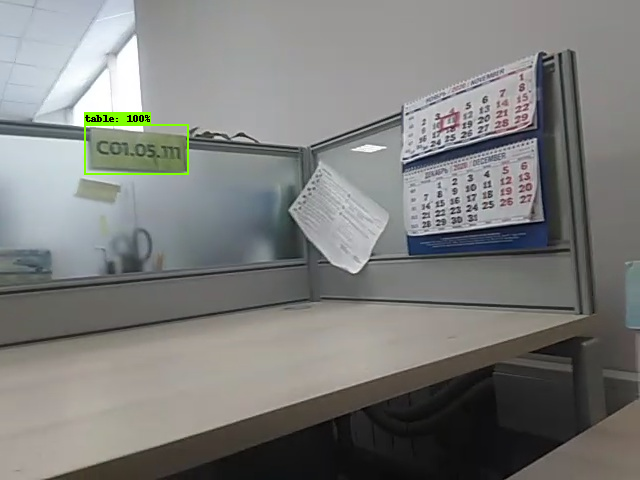

In [38]:
with detection_graph.as_default():
  with tf.Session(graph=detection_graph) as sess:
    while True:
      # Get raw pixels from the screen, save it to a Numpy array
      image_np = np.array(cv2.imread("/content/gdrive/MyDrive/tresh0.7/coco_v3/CSGO_images/train/1.jpg"))
      # To get real color we do this:
      image_np = cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB)
      # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
      image_np_expanded = np.expand_dims(image_np, axis=0)
      # Actual detection.
      image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
      boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
      scores = detection_graph.get_tensor_by_name('detection_scores:0')
      classes = detection_graph.get_tensor_by_name('detection_classes:0')
      num_detections = detection_graph.get_tensor_by_name('num_detections:0')
      # Visualization of the results of a detection.
      (boxes, scores, classes, num_detections) = sess.run(
          [boxes, scores, classes, num_detections],
          feed_dict={image_tensor: image_np_expanded})
      vis_util.visualize_boxes_and_labels_on_image_array(
          image_np,
          np.squeeze(boxes),
          np.squeeze(classes).astype(np.int32),
          np.squeeze(scores),
          category_index,
          use_normalized_coordinates=True,
          line_thickness=2)
      # Show image with detection
      cv2_imshow(cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB))
      # Bellow we calculate our FPS
      break
      fps+=1
      TIME = time.time() - start_time
      if (TIME) >= display_time :
        print("FPS: ", fps / (TIME))
        fps = 0
        start_time = time.time()
      # Press "q" to quit
      if cv2.waitKey(25) & 0xFF == ord("q"):
        cv2.destroyAllWindows()
        break